In [1]:
# Imports
import os
import gdown
import keras
from keras import ops
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from zipfile import ZipFile

Downloading...
From (original): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=b5d68a29-2377-49d0-b18c-0859afba47c0
To: /content/celeba/data.zip
100%|██████████| 1.44G/1.44G [00:37<00:00, 38.2MB/s]


Found 202599 files.


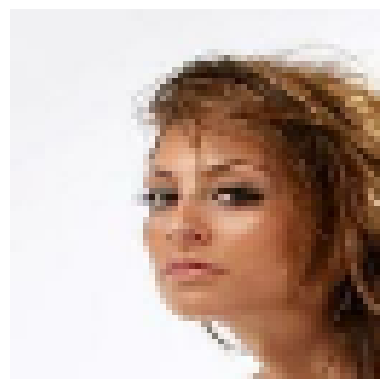

In [2]:
# Pre-process
if not os.path.exists('celeba'):
    os.makedirs('celeba')
url = 'https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684'
output = 'celeba/data.zip'
gdown.download(url, output, quiet = False)

with ZipFile(output, 'r') as zipObj:
    zipObj.extractall('celeba')

dataset = keras.utils.image_dataset_from_directory(
    'celeba', label_mode = None, image_size = (64, 64), batch_size = 32
)
dataset = dataset.map(lambda x: x/255.0) # Normalization
for x in dataset:
    plt.axis('off')
    plt.imshow((x.numpy() * 255).astype('int32')[0])
    break

In [3]:
# Discriminator
D = keras.Sequential([
    keras.Input(shape = (64, 64, 3)),
    layers.Conv2D(64, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(negative_slope = 0.2),
    layers.Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(negative_slope = 0.2),
    layers.Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(negative_slope = 0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'sigmoid')
], name = 'Discriminator')

D.summary()

# Generator
latentZDim = 128
G = keras.Sequential([
    keras.Input(shape = (latentZDim,)),
    layers.Dense(8 * 8 * 128),
    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(negative_slope = 0.2),
    layers.Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(negative_slope = 0.2),
    layers.Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(negative_slope = 0.2),
    layers.Conv2D(3, kernel_size = 3, activation = 'sigmoid', padding = 'same'),
], name = 'Generator')
G.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 8192)                │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 3)           │          13,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,955,075 (15.09 MB)

 Trainable params: 3,955,075 (15.09 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Override Train Step
class GAN(keras.Model):
    def __init__(self, dis, gen, zDim) -> None:
        super().__init__()
        self.dis = dis
        self.gen = gen
        self.zDim = zDim
        self.seedGenerator = keras.random.SeedGenerator(1337)

    def compile(self, dOptim, gOptim, lossFunc):
        super().compile(loss = lossFunc)
        self.dOptim = dOptim
        self.gOptim = gOptim
        self.lossFunc = lossFunc
        self.dLossMetric = keras.metrics.Mean(name = 'DLoss')
        self.gLossMetric = keras.metrics.Mean(name = 'GLoss')

    @property
    def metrics(self):
        return [self.dLossMetric, self.gLossMetric]

    def call(self, inputs):
        # This method should define the forward pass of your GAN
        # For example, you might generate fake images and return them:
        batchSize = ops.shape(inputs)[0]
        latentNoise = keras.random.normal(
            shape = (batchSize, self.zDim), seed = self.seedGenerator
        )
        return self.gen(latentNoise)


    def train_step(self, data):
        realImgs = data
        batchSize = ops.shape(realImgs)[0]
        latentNoise = keras.random.normal(
            shape = (batchSize, self.zDim), seed = self.seedGenerator
        )
        # Here we're generating fake images in batches
        genImgs = self.gen(latentNoise)
        # Concat them with real images
        combinedImgs = ops.concatenate([genImgs, realImgs], axis = 0)
        labels = ops.concatenate([ops.ones((batchSize, 1)), ops.zeros((batchSize, 1))],
                                 axis = 0) # Labeling 1 for gen and 0 for real
        labels += 0.05 * tf.random.uniform(tf.shape(labels)) # !?adding noise trick?!

        # Train Discriminator
        with tf.GradientTape() as tape:
            preds = self.dis(combinedImgs)
            dLoss = self.lossFunc(labels, preds)

        grads = tape.gradient(dLoss, self.dis.trainable_weights)
        self.dOptim.apply_gradients(zip(grads, self.dis.trainable_weights))

        # Train Generator
        latentNoise = keras.random.normal(
            shape = (batchSize, self.zDim), seed = self.seedGenerator
        )
        misleadingLabels = ops.zeros((batchSize, 1)) # Says: All is REAL!

        with tf.GradientTape() as tape:
            preds = self.dis(self.gen(latentNoise))
            gLoss = self.lossFunc(misleadingLabels, preds)

        grads = tape.gradient(gLoss, self.gen.trainable_weights)
        self.gOptim.apply_gradients(zip(grads, self.gen.trainable_weights))

        # Update Metrics
        self.dLossMetric.update_state(dLoss)
        self.gLossMetric.update_state(gLoss)
        return {
            'DLoss': self.dLossMetric.result(),
            'GLoss': self.gLossMetric.result(),
        }

In [5]:
# Callback
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, numImgs = 3, latentDim = 128):
        self.numImgs = numImgs
        self.latentDim = latentDim
        self.seedGenerator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs = None):
        randomLatentVector = keras.random.normal(
            shape = (self.numImgs, self.latentDim), seed = self.seedGenerator
        )
        genImgs = self.model.gen(randomLatentVector)
        genImgs *= 255
        genImgs.numpy()
        for i in range(self.numImgs):
            img = keras.utils.array_to_img(genImgs[i])
            img.save(f'gen_img_{epoch}_{i}.png')

In [ ]:
# Model fit
numEpochs = 10
gan = GAN(dis = D, gen = G, zDim = latentZDim)
gan.compile(
    dOptim = keras.optimizers.Adam(learning_rate = 0.0001),
    gOptim = keras.optimizers.Adam(learning_rate = 0.0001),
    lossFunc = keras.losses.BinaryCrossentropy(),
)
gan.fit(
    dataset, epochs = numEpochs,
    callbacks = [GANMonitor(numImgs = 10, latentDim = latentZDim)]
)

Epoch 1/10
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1452s 227ms/step - DLoss: 0.5570 - GLoss: 1.4030
Epoch 2/10
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1432s 226ms/step - DLoss: 0.6448 - GLoss: 1.0742
Epoch 3/10
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1429s 226ms/step - DLoss: 0.6658 - GLoss: 0.9893
Epoch 4/10
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1430s 226ms/step - DLoss: 0.6454 - GLoss: 1.0716
Epoch 5/10
 914/6332 ━━━━━━━━━━━━━━━━━━━━ 20:29 227ms/step - DLoss: 0.6507 - GLoss: 0.9511